## 任务介绍 
<!-- # 在 TinyStories 数据集上训练一个 BPE 分词器。
# 使用训练好的分词器处理数据集，将其转换为一系列整数 ID。
# 可以使用 torch.nn.Parameter 和 nn中容器类：Module, ModuleList, Sequential, etc.

# 关于 AI 工具的声明，允许对 ChatGPT 等 LLM 进行低级编程问题或关于语言模型的高级概念性问题的提示，但禁止直接使用它来解决问题。
# 我们强烈建议您在完成作业时禁用 IDE 中的 AI 自动完成功能（例如，光标选项卡、GitHub CoPilot）。我们发现，禁用 AI 自动完成功能可以使您更深入地参与内容。 -->

## Unicode 标准


Unicode 是一个将字符映射到整数代码点(整数)的文本编码标准。截至 Unicode 16.0（2024 年 9 月发布），该标准定义了 168 个脚本中的 154,998 个字符。例如，字符“s”的代码点是 115（通常表示为 U+0073，其中 U+是一个惯例前缀，0073 是十六进制的 115），字符“ ”的代码点是 29275。在 Python 中，你可以使用 ord()函数将单个 Unicode 字符转换为它的整数表示。chr()函数将一个整数 Unicode 代码点转换为包含相应字符的字符串。

In [ ]:
#ord()函数将单个 Unicode 字符转换为它的整数表示。
#chr()函数将一个整数 Unicode 代码点转换为包含相应字符的字符串
# ord('国')
# chr(22269)

#问题chr(0)返回什么 Unicode 字符？ 
# chr(0) # '\x00'
# chr(22269) # '国'

#这个字符的字符串表示（__repr__()）与其打印表示有何不同？ 答：在chr()的基础上用""扩起来，而print直接输出chr()''中的内容
# __repr__ → “official string representation” 尽量给出“重建信息”：类名、关键字段、可 eval 的表达式。
# __str__ → “informal string representation”  侧重美观、简洁、去技术细节。
# print(chr(0)) # 空字符
# chr(0).__repr__() # "'\\x00'" #
# print(chr(22269)) # 国
# chr(22269).__repr__() # "'国'"

# chr(0)
# print(chr(0))
"this is a test" + chr(0) + "string"
# print("this is a test" + chr(0) + "string")

'this is a test\x00string'

## Unicode 编码

虽然 Unicode 标准定义了从字符到代码点的映射（整数），但直接在 Unicode 代码点上训练分词器是不切实际的，因为词汇表会非常庞大（大约 150K 项）且稀疏（因为许多字符非常罕见）。相反，我们将使用 Unicode 编码，它将一个 Unicode 字符转换为一个字节序列。Unicode 标准本身定义了三种编码：UTF-8、UTF-16 和 UTF-32，其中 UTF-8 是互联网上主要的编码（所有网页中超过 98% 使用 UTF-8）。

要将 Unicode 字符串编码为 UTF-8，我们可以使用 Python 中的 encode() 函数。要访问 Python bytes 对象的底层字节值，我们可以迭代它（例如，调用 list()）。最后，我们可以使用 decode() 函数将 UTF-8 字节字符串解码为 Unicode 字符串。

In [ ]:
test_str = "hello!       !中国"
utf_8_encode = test_str.encode("utf-8") # 一个中文3字节
utf_16_encode = test_str.encode("utf-16")
utf_32_encode = test_str.encode("utf-32")
print(f"utf_8_encode is: {utf_8_encode}")
print(f"utf_16_encode is: {utf_16_encode}")
print(f"utf_32_encode is: {utf_32_encode}")

# print(f"type(utf_8_encode) is: {type(utf_8_encode)}")
# print(f"list(utf_8_encode) is: {list(utf_8_encode)}")
# print(len(test_str))
# print(len(utf_8_encode))
# print(utf_8_encode.decode("utf-8"))



utf_8_encode is: b'hello!       !\xe4\xb8\xad\xe5\x9b\xbd'
utf_16_encode is: b'\xff\xfeh\x00e\x00l\x00l\x00o\x00!\x00 \x00 \x00 \x00 \x00 \x00 \x00 \x00!\x00-N\xfdV'
utf_32_encode is: b'\xff\xfe\x00\x00h\x00\x00\x00e\x00\x00\x00l\x00\x00\x00l\x00\x00\x00o\x00\x00\x00!\x00\x00\x00 \x00\x00\x00 \x00\x00\x00 \x00\x00\x00 \x00\x00\x00 \x00\x00\x00 \x00\x00\x00 \x00\x00\x00!\x00\x00\x00-N\x00\x00\xfdV\x00\x00'


通过将我们的 Unicode 代码点转换为字节序列（例如，通过 UTF-8 编码），我们实际上是将一系列代码点（0 到 154,997 范围内的整数）转换为一组字节值（0 到 255 范围内的整数）。256 长度的字节词汇表更容易处理。在使用字节级分词时，我们不需要担心词汇表之外的标记，因为我们知道任何输入文本都可以表示为 0 到 255 的整数序列。

- 问题：有哪些原因更倾向于在 UTF-8 编码的字节上训练我们的分词器，而不是 UTF-16 或 UTF-32？比较这些编码在各种输入字符串上的输出可能会有所帮助。
- 答：UTF-8 把 ASCII 字符编成单字节，非 ASCII 最多 4 字节，词汇表小而紧凑；UTF-16/32 固定 2–4 字节或 4 字节，连英文字母都占 2–4 字节，词汇表膨胀、训练数据冗余，模型参数和计算量随之增加。


In [ ]:
# 问题：以下（不正确）的函数，它旨在将 UTF-8 字节字符串解码为 Unicode 字符串。
#       这个函数为什么是不正确的？提供一个输入字节字符串的例子，它会产生不正确的结果。

# 答：逐字节单独解码会破坏多字节序列：UTF-8 中非 ASCII 字符由 2–4 字节组成，
#       拆开后每个孤立字节都不是合法码点，触发 UnicodeDecodeError。
def decode_utf8_bytes_to_str_wrong(bytestring: bytes):
    return "".join([bytes([b]).decode("utf-8") for b in bytestring])

# "中".encode("utf-8") → b'\xe4\xb8\xad'，函数先解 \xe4 即抛异常。
decode_utf8_bytes_to_str_wrong("中".encode("utf-8"))

# 给出一个不会解码为任何 Unicode 字符的两字节序列 
# 0xC0 0x80 — this overlong encoding is explicitly illegal in UTF-8, so no valid Unicode character can be decoded from it.


'0xC00x80'

## 子词分词（Subword Tokenization）
虽然字节级分词可以缓解词级分词面临的词汇表外问题，但将文本分词为字节会导致输入序列变得非常长。这会减慢模型训练速度。
因为一个包含 10 个单词的句子在词级语言模型中可能只有 10 个 token 长，但在字符级模型中可能长达 50 个或更多 token（取决于单词的长度）。处理这些更长的序列需要在模型的每一步进行更多的计算。此外，对字节序列进行语言建模是困难的，因为更长的输入序列会在数据中产生长期依赖关系。

子词分词是词级分词和字节级分词之间的一个中间点。请注意，字节级分词的词汇表有 256 个条目（字节值范围是 0 到 255）。子词分词用更大的词汇表大小来换取输入字节序列更好的压缩效果。例如，如果字节序列 b'the'经常出现在我们的原始文本训练数据中，将其作为一个条目添加到词汇表中，可以将这个 3 个分词的序列减少为一个分词。

我们如何选择这些子词单元添加到我们的词汇表中？Sennrich 等人[2016]提出使用字节对编码（BPE；Gage，1994），这是一种压缩算法，它迭代地将出现频率最高的字节对替换为一个新未使用的索引。请注意，这个算法通过添加子词分词到我们的词汇表来最大化输入序列的压缩效果——如果一个词在我们的输入文本中出现的次数足够多，它将被表示为一个单个的子词单元。

使用 BPE 构建词汇表的子词分词器通常被称为 BPE 分词器。在这个作业中，我们将实现一个字节级 BPE 分词器，其中词汇项是字节或字节合并序列，这让我们在处理未知词汇和可管理的输入序列长度方面都能获得最佳效果。构建 BPE 分词器词汇的过程被称为“训练”BPE 分词器。

## BPE 分词器训练（BPE Tokenizer Training）

BPE 分词器训练过程包括三个主要步骤。

词汇初始化 分词器词汇是从字节串标记到整数 ID 的一对一映射。由于我们正在训练一个字节级 BPE 分词器，我们的初始词汇仅仅是所有字节的集合。由于有 256 种可能的字节值，我们的初始词汇大小为 256。

预分词 一旦你有了词汇表，理论上你可以统计文本中字节相邻出现的频率，并从最频繁的字节对开始合并。然而，这种方法计算成本很高，因为每次合并时我们都需要完整地遍历语料库。此外，直接跨语料库合并字节可能导致仅标点符号不同的标记（例如，dog! 与 dog.）。这些标记会获得完全不同的标记 ID，尽管它们可能在语义上高度相似（因为它们仅差标点符号）。

为了避免这种情况，我们对语料库进行预分词。你可以将其视为一种粗粒度的语料库分词，它帮助我们统计字符对出现的频率。例如，单词 'text' 可能是一个出现 10 次的预标记。在这种情况下，当我们统计字符 't' 和 'e' 相邻出现的频率时，我们会发现单词 'text' 中 't' 和 'e' 是相邻的，我们可以通过 10 次来增加它们的计数，而不是遍历语料库。由于我们正在训练一个基于字节的 BPE 模型，每个预标记都表示为 UTF-8 字节的序列。


Sennrich 等人[2016]最初的 BPE 实现通过简单地按空白字符分割进行预分词（即 s.split(" "））。相比之下，我们将使用基于正则表达式的预分词器（GPT-2 使用；Radford 等人，2019）


然而，在您的代码中使用时，您应该使用 re.finditer 来避免在构建从预标记到其计数的映射时存储预标记的单词。

In [ ]:
# 正则表达式的预分词
#使用这个预分词器交互式地分割一些文本可能有助于更好地理解其行为：
PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""

# requires `regex` package
import regex as re
re.findall(PAT, "some text that i'll pre-tokenize") #['some', ' text', ' that', ' i', "'ll", ' pre', '-', 'tokenize']


### 计算 BPE 合并 
现在，我们已经将输入文本转换为预标记，并将每个预标记表示为 UTF-8 字节的序列，我们可以计算 BPE 合并（即训练 BPE 分词器）。从高层次来看，BPE 算法迭代地统计每一对字节，并识别出现频率最高的那一对（“A”，“B”）。然后，将这一对出现频率最高的字节（“A”，“B”）进行合并，即用一个新的标记“AB”替换。这个新的合并标记被添加到我们的词汇表中；因此，经过 BPE 训练后的最终词汇表大小是初始词汇表的大小（在我们的例子中为 256），加上在训练过程中执行的 BPE 合并操作的次数。为了在 BPE 训练过程中的效率，我们不考虑跨越预标记边界的字节对。在计算合并时，通过优先选择字母顺序更大的字节对来确定性地打破频率平局。例如，如果字节对（“A”，“B”）、（“A”，“C”）、（“B”，“ZZ”）和（“BA”，“A”）都具有最高的频率，我们会合并（“BA”，“A”）：

In [ ]:
max([("A", "B"), ("A", "C"), ("B", "ZZ"), ("BA", "A")])

('BA', 'A')

### 特殊标记 
常常，一些字符串（例如 ǂ）被用来编码元数据（例如文档之间的边界）。在编码文本时，通常希望将某些字符串视为“特殊标记”，这些标记永远不会被拆分成多个标记（即始终作为一个单独的标记保留）。例如，序列结束字符串 ǂ 始终作为一个单独的标记保留（即一个单独的整数 ID），这样我们才知道何时停止从语言模型生成。这些特殊标记必须添加到词汇表中，以便它们有一个对应的固定标记 ID。

Sennrich 等人[2016]的算法 1 包含一个效率低下的 BPE 分词器训练实现（基本上遵循了我们上面概述的步骤）。作为第一个练习，实现并测试这个函数可能有助于测试你的理解。


{low: 5, lower: 2, widest: 3, newest: 6}
将其表示为 dict[tuple[bytes], int]很方便，例如{(l,o,w): 5 …}。请注意，即使是一个字节在 Python 中也是一个 bytes 对象。Python 中没有表示单个字节类型的字节类型，就像 Python 中没有表示单个字符的 char 类型一样。

合并 我们首先查看每一对连续的字节，并计算它们在单词中出现的频率{lo: 7, ow: 7, we: 8, er: 2, wi: 3, id: 3, de: 3, es: 9, st: 9, ne: 6, ew: 6}。('es')和('st')这对并列，所以我们选择字母顺序更大的('st')。然后我们将预标记合并，最终得到{(l,o,w): 5, (l,o,w,e,r): 2, (w,i,d,e,st): 3, (n,e,w,e,st): 6}。

在第二轮中，我们看到(e, st)是最常见的组合（出现次数为 9），我们会将其合并为{(l,o,w): 5, (l,o,w,e,r): 2, (w,i,d,est): 3, (n,e,w,est): 6}。继续这个过程，最终得到的合并序列将是['s t', 'e st', 'o w', 'l ow', 'w est', 'n e', 'ne west', 'w i', 'wi d', 'wid est', 'low e', 'lowe r']。


如果我们进行 6 次合并，我们得到['s t', 'e st', 'o w', 'l ow', 'w est', 'n e']，我们的词汇元素将是[___, [...256 BYTE CHARS], st, est, ow, low, west, ne]。

有了这个词汇和合并集，单词 newest 会被分词为[ne, west]。

### 开始训练BPE 分词器

In [ ]:

让我们在 TinyStories 数据集上训练一个字节级的 BPE 分词器。查找/下载数据集的说明可以在第 1 节找到。
在开始之前，我们建议先查看 TinyStories 数据集，以了解数据中包含的内容。


并行化预分词 你会发现主要的瓶颈是预分词步骤。你可以通过使用内置库 multiprocessing 来并行化你的代码，从而加快预分词的速度。
具体来说，我们建议在预分词的并行实现中，将语料库分块，同时确保你的分块边界出现在特殊标记的开始处。
你可以直接使用以下链接中的启动代码来获取分块边界，然后使用这些边界来分配工作到你的进程：
https://github.com/stanford-cs336/assignment1-basics/blob/main/cs336_basics/pretokenization_example.py

这种分块将始终是有效的，因为我们永远不会跨文档边界进行合并。对于作业的目的，你可以始终以这种方式进行分割。不用担心收到一个非常大的语料库，该语料库不包含 的边缘情况。

在预分词之前移除特殊标记 在使用正则表达式模式（通过 re.finditer）运行预分词之前，你应该从你的语料库（如果使用并行实现，则是你的数据块）中移除所有特殊标记。确保你基于特殊标记进行分割，这样它们所界定文本之间就不会发生合并。例如，如果你有一个语料库（或数据块）如 [Doc 1] [Doc 2]，你应该基于特殊标记 进行分割，并分别对 [Doc 1] 和 [Doc 2] 进行预分词，以防止文档边界之间的合并。这可以通过使用 re.split 和 "|" .join(special_tokens) 作为分隔符来完成（需要小心使用 re.escape，因为 | 可能会出现在特殊标记中）。test test_train_bpe_special_tokens 测试将检查这一点。

优化合并步骤 BPE 训练在上述风格化示例中的朴素实现之所以缓慢，是因为对于每次合并，它都会遍历所有字节对来识别最频繁的对。然而，每次合并后唯一会改变的计数对是与合并对重叠的那些。因此，可以通过索引所有对的计数并增量更新这些计数来提高 BPE 训练速度，而不是显式地遍历每个字节对来计算对频率。使用这种缓存过程可以显著提高速度，尽管我们注意到 BPE 训练的合并部分在 Python 中不可并行化。

In [21]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories", split="train")

# ds[0]["text"]



Using the latest cached version of the dataset since roneneldan/TinyStories couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/zhouwenxing/.cache/huggingface/datasets/roneneldan___tiny_stories/default/0.0.0/f54c09fd23315a6f9c86f9dc80f725de7d8f9c64 (last modified on Tue Jan  6 20:31:59 2026).


In [12]:
# 例子中给的参考代码

import os
from typing import BinaryIO

# gpt2- style pre-tokenization pattern
PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""

def find_chunk_boundaries(
    file: BinaryIO,
    desired_num_chunks: int,
    split_special_token: bytes,
) -> list[int]:
    """
    将文件分块为可以独立计数的部分。如果边界重叠，返回的块可能会更少。
    """
    assert isinstance(split_special_token, bytes), "必须将特殊标记表示为字节字符串"

    # 获取文件总大小（字节）
    file.seek(0, os.SEEK_END)
    file_size = file.tell()
    file.seek(0)

    chunk_size = file_size // desired_num_chunks

    # 块边界位置的初始猜测，均匀分布
    # 块从上一个索引开始，不包括最后一个索引
    chunk_boundaries = [i * chunk_size for i in range(desired_num_chunks + 1)]
    chunk_boundaries[-1] = file_size

    mini_chunk_size = 4096  # 每次预读4KB

    for bi in range(1, len(chunk_boundaries) - 1):
        initial_position = chunk_boundaries[bi]
        file.seek(initial_position)  # 从边界猜测位置开始
        while True:
            mini_chunk = file.read(mini_chunk_size)  # 读取一个小块

            # 如果到达文件末尾，该边界应位于文件末尾
            if mini_chunk == b"":
                chunk_boundaries[bi] = file_size
                break

            # 查找小块中的特殊标记
            found_at = mini_chunk.find(split_special_token)
            if found_at != -1:
                chunk_boundaries[bi] = initial_position + found_at
                break
            initial_position += mini_chunk_size

    # 确保所有边界唯一，但可能少于期望的块数
    return sorted(set(chunk_boundaries))

with open(..., "rb") as f:
    num_processes = 4
    boundaries = find_chunk_boundaries(f, num_processes, b"<|endoftext|>")

    # The following is a serial implementation, but you can parallelize this
    # by sending each start/end pair to a set of processes.
    for start, end in zip(boundaries[:-1], boundaries[1:]):
        f.seek(start)
        chunk = f.read(end - start).decode("utf-8", errors="ignore")
        # Run pre-tokenization on your chunk and store the counts for each pre-token

In [ ]:
import regex as re
from collections import Counter, defaultdict
import os

# 字节级 (bytes)
def train_bpe(input_path: str, vocab_size: int, special_tokens: list[str]) -> tuple[dict[int, bytes], list[tuple[bytes, bytes]]]:
    """
    训练字节级 BPE 分词器，使用分块读取优化预分词步骤。
    
    参数:
        input_path: 训练数据的路径。
        vocab_size: 目标词汇表大小。
        special_tokens: 特殊标记列表。
    返回：
        词汇表（id -> 字节串）和合并列表（每个合并为字节对的元组）。
    """
    # 1. 词汇表初始化 (256字节 + 特殊标记)
    vocab = {i: bytes([i]) for i in range(256)}
    for i, st in enumerate(special_tokens):
        vocab[256 + i] = st.encode("utf-8")
    
    num_merges = vocab_size - len(vocab)
    if num_merges <= 0:
        return vocab, []

    # 2. 预分词阶段：使用指定的 find_chunk_boundaries 逻辑进行二进制分块读取
    words_cnts = Counter()
    PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    
    # 获取主分割标记（通常是文档结束符）
    split_token = special_tokens[0].encode("utf-8") if special_tokens else b"<|endoftext|>"
    
    with open(input_path, "rb") as f:
        # 使用 find_chunk_boundaries 进行分块 (例如分成 8 块)
        num_chunks = 8
        boundaries = find_chunk_boundaries(f, num_chunks, split_token)
        
        # 记录特殊标记的模式，用于在块内进一步分割
        if special_tokens:
            special_pattern = "|".join(re.escape(st) for st in special_tokens)
        else:
            special_pattern = None

        for start, end in zip(boundaries[:-1], boundaries[1:]):
            f.seek(start)
            chunk_data = f.read(end - start)
            
            # 将块解码为文本（忽略损坏的字节）
            text_chunk = chunk_data.decode("utf-8", errors="ignore")
            
            # 在块内根据特殊标记分割子块，确保不跨界合并
            if special_pattern:
                sub_chunks = [c for c in re.split(f"({special_pattern})", text_chunk) if c and c not in special_tokens]
            else:
                sub_chunks = [text_chunk]
                
            # 执行预分词计数
            for sub in sub_chunks:
                for m in re.finditer(PAT, sub):
                    token_bytes = m.group().encode("utf-8")
                    token_tuple = tuple(bytes([b]) for b in token_bytes)
                    words_cnts[token_tuple] += 1

    # 3. 初始化合并所需的数据结构
    # data: [[tokens_list, count]]
    data = []
    pair_cnts = Counter()
    # pair_to_words: pair -> {word_idx: count_in_word}
    pair_to_words = defaultdict(lambda: defaultdict(int))
    
    for word_tuple, count in words_cnts.items():
        w_idx = len(data)
        tokens = list(word_tuple)
        data.append([tokens, count])
        for i in range(len(tokens) - 1):
            pair = (tokens[i], tokens[i+1])
            pair_cnts[pair] += count
            pair_to_words[pair][w_idx] += 1

    merges = []
    
    # 4. 合并迭代
    for _ in range(num_merges):
        if not pair_cnts: break
        
        # 挑选最高频且字典序最大的对
        max_f = max(pair_cnts.values())
        best_pair = max(p for p, f in pair_cnts.items() if f == max_f)
        
        merges.append(best_pair)
        new_token = best_pair[0] + best_pair[1]
        next_id = len(vocab)
        vocab[next_id] = new_token
        
        # 增量更新受影响的词和对
        target_word_indices = pair_to_words[best_pair]
        del pair_cnts[best_pair]
        del pair_to_words[best_pair]
        
        for w_idx in list(target_word_indices.keys()):
            tokens, w_freq = data[w_idx]
            
            # 采用“全文替换+局部统计”的简化高效策略
            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i+1]) == best_pair:
                    # 合并前：扣除周边可能受影响的对
                    if i > 0:
                        p = (tokens[i-1], tokens[i])
                        pair_cnts[p] -= w_freq
                        pair_to_words[p][w_idx] -= 1
                        if pair_to_words[p][w_idx] <= 0: del pair_to_words[p][w_idx]
                    
                    if i + 2 < len(tokens):
                        p = (tokens[i+1], tokens[i+2])
                        pair_cnts[p] -= w_freq
                        pair_to_words[p][w_idx] -= 1
                        if pair_to_words[p][w_idx] <= 0: del pair_to_words[p][w_idx]
                    
                    # 执行合并过程
                    new_tokens.append(new_token)
                    
                    # 合并后：增加新产生的对
                    if len(new_tokens) > 1:
                        new_p = (new_tokens[-2], new_tokens[-1])
                        pair_cnts[new_p] += w_freq
                        pair_to_words[new_p][w_idx] += 1
                        
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    # 如果刚才合并了且当前是不匹配项，新对已经在合并分支处理了
                    # 这里如果是普通流动，不需要额外更新，因为 pair_cnts 没变
                    i += 1
            
            data[w_idx][0] = new_tokens
            
        # 清理频率为 0 的对
        pair_cnts = Counter({p: f for p, f in pair_cnts.items() if f > 0})

    return vocab, merges


In [5]:
vocab = {i: bytes([i]) for i in range(256)}
print(f"vocab: {vocab}")

vocab: {0: b'\x00', 1: b'\x01', 2: b'\x02', 3: b'\x03', 4: b'\x04', 5: b'\x05', 6: b'\x06', 7: b'\x07', 8: b'\x08', 9: b'\t', 10: b'\n', 11: b'\x0b', 12: b'\x0c', 13: b'\r', 14: b'\x0e', 15: b'\x0f', 16: b'\x10', 17: b'\x11', 18: b'\x12', 19: b'\x13', 20: b'\x14', 21: b'\x15', 22: b'\x16', 23: b'\x17', 24: b'\x18', 25: b'\x19', 26: b'\x1a', 27: b'\x1b', 28: b'\x1c', 29: b'\x1d', 30: b'\x1e', 31: b'\x1f', 32: b' ', 33: b'!', 34: b'"', 35: b'#', 36: b'$', 37: b'%', 38: b'&', 39: b"'", 40: b'(', 41: b')', 42: b'*', 43: b'+', 44: b',', 45: b'-', 46: b'.', 47: b'/', 48: b'0', 49: b'1', 50: b'2', 51: b'3', 52: b'4', 53: b'5', 54: b'6', 55: b'7', 56: b'8', 57: b'9', 58: b':', 59: b';', 60: b'<', 61: b'=', 62: b'>', 63: b'?', 64: b'@', 65: b'A', 66: b'B', 67: b'C', 68: b'D', 69: b'E', 70: b'F', 71: b'G', 72: b'H', 73: b'I', 74: b'J', 75: b'K', 76: b'L', 77: b'M', 78: b'N', 79: b'O', 80: b'P', 81: b'Q', 82: b'R', 83: b'S', 84: b'T', 85: b'U', 86: b'V', 87: b'W', 88: b'X', 89: b'Y', 90: b'Z', 91

In [24]:
# 准备测试数据并运行训练
import os

# 将 TinyStories 的验证集保存到一个临时文本文件中用于训练
training_file = "tinystories_val_sample.txt"
with open(training_file, "w", encoding="utf-8") as f:
    # 只取前 100000 条记录进行快速测试
    for i in range(min(100000, len(ds))):
        f.write(ds[i]["text"] + "\n")

# 设置训练参数
V_SIZE = 512
SPECIAL = ["<|endoftext|>"]

print(f"开始训练 BPE，目标词汇大小: {V_SIZE}")
vocab, merges = train_bpe(training_file, V_SIZE, SPECIAL)

开始训练 BPE，目标词汇大小: 512


In [26]:
print(f"\n训练完成！")
print(f"最终词汇表大小: {len(vocab)}")
# 打印vocab
for k, v in list(vocab.items())[:5]:
    print(f"  {k}: {v}")
# 打印merges
for i, merge in enumerate(merges[:5]):
    print(f"  {i+1}: {merge[0]} + {merge[1]} -> {merge[0] + merge[1]}")

# print(f"合并次数: {len(merges)}")

# # 打印一些合并示例
# print("\n前 10 个合并:")
# for i, merge in enumerate(merges[:10]):
#     print(f"  {i+1}: {merge[0]} + {merge[1]} -> {merge[0] + merge[1]}")

# # 打印一些非字节标记
# print("\n词汇表中的一些长标记:")
# long_tokens = [v for k, v in vocab.items() if len(v) > 1][:10]
# for token in long_tokens:
#     print(f"  {token}")



训练完成！
最终词汇表大小: 512
  0: b'\x00'
  1: b'\x01'
  2: b'\x02'
  3: b'\x03'
  4: b'\x04'
  1: b'h' + b'e' -> b'he'
  2: b' ' + b't' -> b' t'
  3: b' ' + b'a' -> b' a'
  4: b' ' + b's' -> b' s'
  5: b' ' + b'w' -> b' w'


Matplotlib is building the font cache; this may take a moment.
/var/folders/fv/90bs7bdn601b7j2j04wynnh40000gn/T/ipykernel_56007/3258047333.py:105: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fv/90bs7bdn601b7j2j04wynnh40000gn/T/ipykernel_56007/3258047333.py:105: UserWarning: Glyph 35762 (\N{CJK UNIFIED IDEOGRAPH-8BB2}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fv/90bs7bdn601b7j2j04wynnh40000gn/T/ipykernel_56007/3258047333.py:105: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fv/90bs7bdn601b7j2j04wynnh40000gn/T/ipykernel_56007/3258047333.py:105: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fv/90bs7bdn601b7j2j04wynnh40000gn/T/ipykernel_56007/3258047333.py:105: UserWarning: Glyph 25749 (\N{CJK UNIFIED IDEOGRAPH-6495}

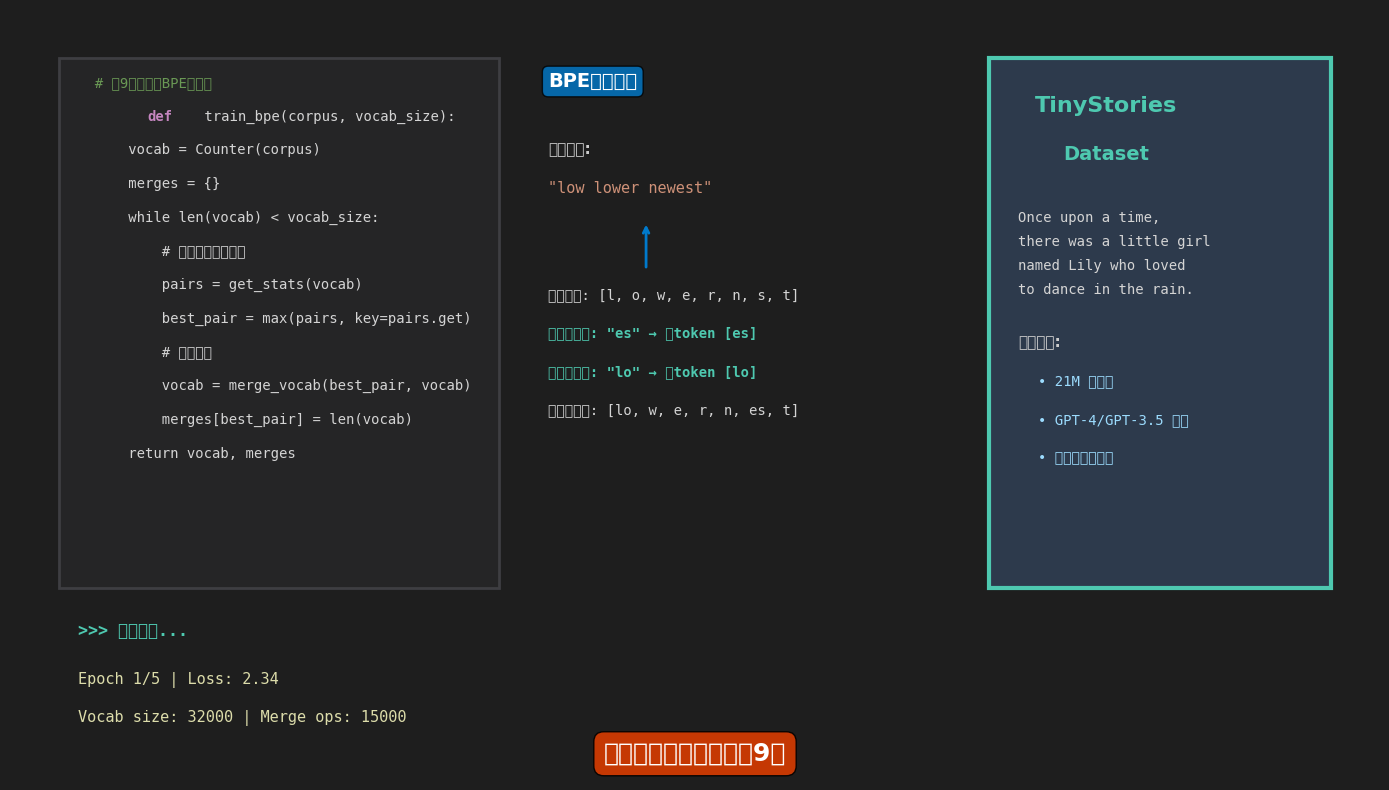

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# 创建画布
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#1e1e1e')
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# 左侧：代码编辑器区域
code_box = Rectangle((0.5, 2), 4.5, 5.5, facecolor='#252526', edgecolor='#3e3e42', linewidth=2)
ax.add_patch(code_box)

# 代码高亮颜色
keyword_color = '#c586c0'
func_color = '#4ec9b0'
string_color = '#ce9178'
comment_color = '#6a9955'

# 代码内容
code_lines = [
    "  # 第9讲：手撕BPE分词器",
    "  def train_bpe(words, vocab_size):",
    "      vocab = Counter(words)",
    "      merges = {}",
    "      while len(vocab) < vocab_size:",
    "          # 统计最频繁字节对",
    "          pairs = get_stats(vocab)",
    "          best_pair = max(pairs, key=pairs.get)",
    "          # 执行合并",
    "          vocab = merge_vocab(best_pair, vocab)",
    "          merges[best_pair] = len(vocab)",
    "      return vocab, merges"
]

y_pos = 7.2
for i, line in enumerate(code_lines):
    if i == 0:  # 注释
        ax.text(0.7, y_pos, line, fontsize=10, color=comment_color, fontfamily='monospace')
    elif i == 1:  # 函数定义
        parts = line.split('def')
        ax.text(0.7, y_pos, parts[0], fontsize=10, color='#d4d4d4', fontfamily='monospace')
        ax.text(1.4, y_pos, 'def', fontsize=10, color=keyword_color, fontweight='bold', fontfamily='monospace')
        ax.text(1.9, y_pos, parts[1], fontsize=10, color='#d4d4d4', fontfamily='monospace')
    else:
        ax.text(0.7, y_pos, line, fontsize=10, color='#d4d4d4', fontfamily='monospace')
    y_pos -= 0.35

# 中间：BPE合并过程可视化
merge_title = ax.text(5.5, 7.2, 'BPE合并过程', fontsize=14, color='#ffffff', fontweight='bold')
merge_title.set_bbox(dict(boxstyle="round,pad=0.3", facecolor='#007acc', alpha=0.8))

# 输入文本
ax.text(5.5, 6.5, '原始文本:', fontsize=11, color='#cccccc', fontweight='bold')
ax.text(5.5, 6.1, '"low lower newest"', fontsize=11, color=string_color, fontfamily='monospace')

# 箭头
ax.annotate('', xy=(6.5, 5.8), xytext=(6.5, 5.3), 
            arrowprops=dict(arrowstyle='->', color='#007acc', lw=2))

# token化步骤
ax.text(5.5, 5.0, '初始词汇: [l, o, w, e, r, n, s, t]', fontsize=10, color='#d4d4d4', fontfamily='monospace')
ax.text(5.5, 4.6, '第一次合并: "es" → 新token [es]', fontsize=10, color='#4ec9b0', fontfamily='monospace', fontweight='bold')
ax.text(5.5, 4.2, '第二次合并: "lo" → 新token [lo]', fontsize=10, color='#4ec9b0', fontfamily='monospace', fontweight='bold')
ax.text(5.5, 3.8, '最终词汇表: [lo, w, e, r, n, es, t]', fontsize=10, color='#d4d4d4', fontfamily='monospace')

# 右侧：TinyStories数据集标识
tiny_box = Rectangle((10, 2), 3.5, 5.5, facecolor='#2d3a4c', edgecolor='#4ec9b0', linewidth=3)
ax.add_patch(tiny_box)

ax.text(11.2, 7.0, 'TinyStories', fontsize=16, color='#4ec9b0', fontweight='bold', 
        ha='center', va='center')
ax.text(11.2, 6.5, 'Dataset', fontsize=14, color='#4ec9b0', fontweight='bold', 
        ha='center', va='center')

# 故事示例
story_text = [
    "Once upon a time,",
    "there was a little girl",
    "named Lily who loved",
    "to dance in the rain."
]

y_story = 5.8
for line in story_text:
    ax.text(10.3, y_story, line, fontsize=10, color='#d4d4d4', fontfamily='monospace')
    y_story -= 0.25

# 数据集统计
ax.text(10.3, 4.5, '统计信息:', fontsize=11, color='#cccccc', fontweight='bold')
ax.text(10.5, 4.1, '• 21M 短故事', fontsize=10, color='#9cdcfe', fontfamily='monospace')
ax.text(10.5, 3.7, '• GPT-4/GPT-3.5 生成', fontsize=10, color='#9cdcfe', fontfamily='monospace')
ax.text(10.5, 3.3, '• 适合分词器训练', fontsize=10, color='#9cdcfe', fontfamily='monospace')

# 底部装饰：代码运行符号
ax.text(0.7, 1.5, '>>> 正在训练...', fontsize=12, color='#4ec9b0', fontfamily='monospace', fontweight='bold')
ax.text(0.7, 1.0, 'Epoch 1/5 | Loss: 2.34', fontsize=11, color='#dcdcaa', fontfamily='monospace')
ax.text(0.7, 0.6, 'Vocab size: 32000 | Merge ops: 15000', fontsize=11, color='#dcdcaa', fontfamily='monospace')

# 顶部装饰：系列标题
series_title = ax.text(7, 0.2, '《手撕大模型》系列第9期', fontsize=18, color='#ffffff', fontweight='bold', ha='center')
series_title.set_bbox(dict(boxstyle="round,pad=0.4", facecolor='#d83b01', alpha=0.9))

plt.tight_layout()
plt.savefig('bpe_tokenizer_training.jpg', dpi=300, facecolor='#1e1e1e', bbox_inches='tight')
plt.show()

In [ ]:
# ==========================================
# 面试专用版 BPE 训练代码 (简化文件处理，核心逻辑通用) 字节级 (bytes)
# ==========================================
import regex as re
from collections import Counter

def train_bpe_simple(input_path, vocab_size, special_tokens):
    """
    简化版 BPE 训练函数，适合手撕代码面试。
    省略了复杂的多进程/分块文件读取，保留了 BPE 的核心逻辑。
    
    参数:
        input_path (str): 训练数据文件路径
        vocab_size (int): 目标词汇表大小
        special_tokens (list[str]): 特殊标记列表，如 ["<|endoftext|>"]
        
    返回:
        vocab (dict): ID 到字节的映射
        merges (list): 合并规则列表
    """
    
    # --- 1. 初始化词汇表 ---
    # 基础词表：0-255 的所有单字节
    # BPE 的基石是字符/字节，我们从所有可能的字节开始
    vocab = {i: bytes([i]) for i in range(256)}
    
    # 添加特殊标记到词表
    # 特殊标记通常用于控制生成过程，如结束符等
    for i, token in enumerate(special_tokens):
        vocab[256 + i] = token.encode("utf-8")
        
    # 计算还需要合并多少次才能达到目标词表大小
    # 每次合并都会增加一个新词，所以需要的合并次数 = 目标大小 - 初始大小
    num_merges = vocab_size - len(vocab)
    
    # --- 2. 读取文件并预处理 ---
    # 在面试中，通常假设文件能一次性读入或者是简单的字符串列表
    if os.path.exists(input_path):
        with open(input_path, "r", encoding="utf-8") as f:
            text = f.read()
    else:
        # 如果文件不存在（测试用），直接用一些简单文本替代
        text = "hello hello world world"
        
    # 使用 regex 进行预分词 (GPT-2 风格)
    # 这一步是为了把文本切分成一个个单词，BPE 只在单词内部合并，不跨单词合并
    # 比如 "dog." 会被切分成 "dog" 和 "."，避免合并出 "g." 这种奇怪的 token
    PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    
    # 统计每个单词的出现频率
    # 比如文本是 "hello hello world"，那么 words_cnts = {("h","e","l","l","o"): 2, ("w","o","r","l","d"): 1}
    # 注意：我们将单词转换为【元组】，每个元素初始时是一个字节
    # 使用元组是因为它是不可变的，可以作为字典的键
    word_counts = Counter()
    for word in re.findall(PAT, text): # 简单起见直接 findall
        # 单词转 UTF-8 字节 -> 每个字节转成独立的 bytes 对象 -> 存入元组
        word_bytes = [bytes([b]) for b in word.encode("utf-8")]
        word_counts[tuple(word_bytes)] += 1

    merges = [] # 记录合并规则
    
    # --- 3. BPE 主循环 ---
    for i in range(num_merges):
        # 3.1 统计当前所有相邻字节对的频率
        # 这一步在面试版可以写得简单直观些，虽然效率不如增量更新，但逻辑最好懂
        pair_counts = Counter()
        for word_tuple, freq in word_counts.items():
            # 遍历当前单词中的所有相邻对
            for j in range(len(word_tuple) - 1):
                pair = (word_tuple[j], word_tuple[j+1])
                pair_counts[pair] += freq # 加上这个单词出现的频次
        
        # 如果没有对可以合并了（例如都是单字节单词），提前结束
        if not pair_counts:
            break
            
        # 3.2 找到频率最高的对
        # max() 默认只比较 value (key 冲突时比较 key)，我们这里显式指定：
        # 先按频率(freq)排序，频率相同按字节对(pair)的字典序排序（保证确定性）
        best_pair = max(pair_counts, key=lambda p: (pair_counts[p], p))
        
        # 3.3 记录合并结果
        merges.append(best_pair)
        # 生成新 token：把两个字节串拼起来
        new_token = best_pair[0] + best_pair[1] 
        # 添加到词表，注意 ID 是累加的
        vocab[len(vocab)] = new_token 
        
        # 3.4 更新所有单词状态 (执行合并)
        # 遍历所有单词，把其中的 best_pair 替换成 new_token
        # 比如 best_pair 是 ('h', 'e') -> 'he'
        # 那么 ('h', 'e', 'l', 'l', 'o') 就会变成 ('he', 'l', 'l', 'o')
        new_word_counts = Counter()
        for word_tuple, freq in word_counts.items():
            new_tuple = []
            j = 0
            while j < len(word_tuple):
                # 检查当前位置 j 和 j+1 是否刚好是 best_pair
                if j < len(word_tuple) - 1 and (word_tuple[j], word_tuple[j+1]) == best_pair:
                    new_tuple.append(new_token) # 替换为新 token
                    j += 2 # 跳过两个被合并的元素
                else:
                    new_tuple.append(word_tuple[j]) # 保持原样
                    j += 1
            
            # 更新这个单词的新形态
            new_word_counts[tuple(new_tuple)] += freq
            
        # 用更新后的字典替换旧的，进入下一轮循环
        word_counts = new_word_counts
        
    return vocab, merges

# 测试一下面试版代码
print("运行简化版 BPE 训练...")
simple_vocab, simple_merges = train_bpe_simple("tinystories_val_sample.txt", 300, ["<|endoftext|>"])
print(f"训练完成！词表大小: {len(simple_vocab)}")
if simple_merges:
    print(f"前5个合并: {simple_merges[:5]}")
else:
    print("没有发生合并（可能是数据太少了）")


运行简化版 BPE 训练...
训练完成！词表大小: 300
前5个合并: [(b'h', b'e'), (b' ', b't'), (b' ', b'a'), (b' ', b's'), (b' ', b'w')]


In [ ]:
# ==========================================
# 【极简版】面试手撕 BPE 代码 (约30行核心逻辑)
# ==========================================
# 特点：使用字符级(而非字节级)，更直观易懂，适合白板手写
# ==========================================

from collections import Counter

def train_bpe_mini(words: list[str], vocab_size: int):
    """
    极简 BPE 训练，面试专用。
    
    参数:
        words: 语料库，比如 ["low", "lower", "newest", "widest"]
        vocab_size: 目标词汇表大小
    返回:
        vocab: 最终词汇表 (set)
        merges: 合并规则列表 [(a,b), ...]
    """
    
    # ========== 第1步：初始化 ==========
    # 把每个单词拆成字符列表，并统计词频
    # 例如: {"low": 5} -> {('l','o','w'): 5}
    words_cnts = Counter()
    for word in words:
        words_cnts[tuple(word)] += 1
    
    # 【关键】初始词汇表 = 所有出现过的字符
    vocab = set()
    for word in words:
        vocab.update(word)  # 把每个字符加入词汇表
    
    # 计算需要合并的次数: 目标大小 - 初始大小
    num_merges = vocab_size - len(vocab)
    
    merges = []  # 记录合并规则
    
    # ========== 第2步：BPE 主循环 ==========
    for _ in range(num_merges):
        
        # --- 2.1 统计所有相邻字符对的频率 ---
        pair_counts = Counter()
        # {('l','o','w'): 5}
        for word_tuple, freq in words_cnts.items():
            for i in range(len(word_tuple) - 1):
                pair = (word_tuple[i], word_tuple[i+1])
                pair_counts[pair] += freq
        
        # 如果没有可合并的对了，退出
        if not pair_counts:
            break
        
        # --- 2.2 找出频率最高的对 ---
        best_pair = max(pair_counts, key=pair_counts.get)
        merges.append(best_pair)
        
        # --- 2.3 在所有单词中执行合并 ---
        new_token = best_pair[0] + best_pair[1]  # 如 ('e','s') -> 'es'
        vocab.add(new_token)  # 【关键】新token加入词汇表
        
        # 构建新的词频字典
        new_words_cnts = Counter()
        # {('l','o','w'): 5}
        for word_tuple, freq in words_cnts.items():
            new_word = []
            i = 0
            while i < len(word_tuple):
                # 检查当前位置和下一个位置是否是 best_pair
                if i < len(word_tuple) - 1 and (word_tuple[i], word_tuple[i+1]) == best_pair:
                    new_word.append(new_token)
                    i += 2
                # 否则保持原样
                else:
                    new_word.append(word_tuple[i])
                    i += 1
            new_words_cnts[tuple(new_word)] += freq
        
        words_cnts = new_words_cnts
    
    return vocab, merges


# ==========================================
# 测试：使用论文中的经典例子
# ==========================================
words = ["low"] * 5 + ["lower"] * 2 + ["newest"] * 6 + ["widest"] * 3

print("=" * 50)
print("【极简版 BPE 演示】")
print("=" * 50)

# 先看初始词汇表
init_vocab = set()
for w in words:
    init_vocab.update(w)
print(f"初始词汇表: {init_vocab} (大小={len(init_vocab)})")

# 设置目标词汇表大小
target_vocab_size = 18  # 初始8个字符 + 10次合并
print(f"目标词汇表大小: {target_vocab_size}")
print()

vocab, merges = train_bpe_mini(words, vocab_size=target_vocab_size)

print(f"执行 {len(merges)} 次合并后:")
print(f"  合并规则: {merges}")
print(f"  最终词汇表大小: {len(vocab)}")
print(f"  最终词汇表: {vocab}")

【极简版 BPE 演示】
初始词汇表: {'r', 'e', 'l', 'o', 'i', 't', 'd', 'w', 'n', 's'} (大小=10)
目标词汇表大小: 18

执行 8 次合并后:
  合并规则: [('e', 's'), ('es', 't'), ('l', 'o'), ('lo', 'w'), ('n', 'e'), ('ne', 'w'), ('new', 'est'), ('w', 'i')]
  最终词汇表大小: 18
  最终词汇表: {'r', 'es', 'e', 'newest', 'new', 'l', 'o', 'i', 'lo', 't', 'd', 'ne', 'w', 'wi', 'est', 'low', 'n', 's'}


In [ ]:
from collections import Counter

def Byte_pair_encode_tokenizer_train(words, vocab_size):
    # words: 语料库，比如 ["low", "lower", "newest", "widest"]

    # step1 统计初始词频
    words_cnt = Counter()
    for word in words:
        # {"low": 1} -> {('l','o','w'): 1}
        words_cnt[tuple(word)] += 1
    
    # step2 初始化词表为words中最小字母集合
    vocab = set() # vocab = []：列表没有 .update() 方法，只有 set 或 dict 有
    # 初始词汇表 10 个字符: {r, e, l, o, i, t, d, w, n, s}
    for word in words:
        vocab.update(word) # vocab.update(string) 等同于 for char in word: vocab.add(char)。

    # step3 计算需要合并的次数
    merge_num = vocab_size - len(vocab)
    # merge_list记录合并过程
    merge_list = [] 

    # step4 开始bpe主循环
    for i in range(merge_num):
        # step4.1 统计所有相邻字符对的次数
        pair_cnt = Counter()
        for word_tuple, cnt in words_cnt.items():
            # 遍历word_tuple ('l','o','w') [0, n - 2] 这是pair对的第一个元素，pair对第二个元素范围[1,n-1]
            for i in range(len(word_tuple) - 1):
                # pair = tuple(word_tuple[i], word_tuple[i+1])
                pair = (word_tuple[i], word_tuple[i+1])
                pair_cnt[pair] += cnt
        
        # step4.2 拿到出现次数最多的pair，并合并放到词汇表 放到merge_list中
        best_pair = max(pair_cnt, key=pair_cnt.get) # 这里的key=pair_cnt.get有什么用？
        best_word = best_pair[0] + best_pair[1]  # 如 ('e','s') -> 'es'

        vocab.add(best_word)  # 【关键】新token加入词汇表
        merge_list.append(best_pair) # 记录合并过程

        # step4.3 更新词频
        words_cnt_new = Counter()
        for word_tuple, cnt in words_cnt.items:
            # # {"low": 1} -> {('l','o','w'): 1}
            # for i in range(len(word_tuple) - 1):
            new_word = [] # 更新后的word_tuple
            i = 0
            while i < len(word_tuple):
                # 如果当前word_tuple的相临元素是best_pair
                if i < len(word_tuple) - 1 and (word_tuple[i], word_tuple[i+1]) == best_pair:
                    new_word.append(best_word)
                    i += 2
                else:
                    new_word.append(word_tuple[i])
                    i += 1
            words_cnt_new[tuple(new_word)] += cnt
        
        words_cnt = words_cnt_new
    return vocab, merge_list



import regex as re


# 1. 准备原始文本（通常包含多个文档）
raw_text = "Once upon a time... <|endoftext|> Next story begins..."

# 2. 预分词模式 (GPT-2 风格)
PAT = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""

# 3. 生成 words 列表
# 注意：要把文档分隔符特殊处理，或者在 findall 后过滤掉
words = re.findall(PAT, raw_text)

# 4. 调用你的 BPE 函数
# 注意：如果 vocab_size 包含特殊 token，计算 merge_num 时要减去它们的数量
special_tokens = ["<|endoftext|>"]
vocab, merges = Byte_pair_encode_tokenizer_train(words, vocab_size)

# 手动将特殊 token 加入最终 vocab
for st in special_tokens:
    vocab.add(st)

















### 0111重写. Byte-Pair Encoding (BPE)

In [28]:
from collections import Counter
import re

class BPE0111:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.vocab = {}
        self.merges = []
    
    def train(self, words):
        # words: 语料库，比如 ["low", "lower", "newest", "widest"]
        # step1 统计初始词频
        tuple_freq = Counter()
        for word in words:
            # word:low -> word_tuple: ('l','o','w')
            word_tuple = tuple(word)
            tuple_freq[word_tuple] += 1
        
        # step2 初始化词表 vocab 为所有单词中不重复字符数量
        self.vocab = set()
        for word in words:
            # vocab.update(word) 等价于 for ch in word: vocab.add(ch)
            self.vocab.update(word)
            # for ch in word:
            #     vocab.add(ch)
        
        # step3 计算要合并的次数
        need_merge_num = self.vocab_size - len(self.vocab)

        # step4 开始执行bpe合并逻辑（BPE主流程）
        for i in range(need_merge_num):
            # step4.1 统计所有相邻pair对的词频
            pair_freq = Counter()
            for word_tuple, cnt in tuple_freq.items():
                n = len(word_tuple)
                for i in range(n-1): # 遍历pair对的左边[0, n-2] 因为(n-2,n-1)是最后一个pair对
                    pair = (word_tuple[i], word_tuple[i + 1])
                    pair_freq[pair] += cnt

            # step4.2 选出现次数最多的pair 组合到一起，放到vocab中，并将组合过程放到merges中
            target_pair = max(pair_freq, key=pair_freq.get)
            target_word = "".join(target_pair)

            self.merges.append(target_pair)
            self.vocab.add(target_word)

            # step4.3 更新词频 tuple_freq
            new_tuple_freq = Counter()
            for word_tuple, cnt in tuple_freq.items():
                i = 0
                n = len(word_tuple)
                new_word = []
                while i < n: # 改为 i < n 确保不丢失最后一个字符
                    if i < n - 1 and (word_tuple[i], word_tuple[i+1]) == target_pair:
                        new_word.append(word_tuple[i] + word_tuple[i+1]) # 下面也行
                        # new_word.append(target_word) 
                        i += 2
                    else:
                        new_word.append(word_tuple[i])
                        i += 1
                
                # word:low -> word_tuple: ('l','o','w')
                new_word_tuple = tuple(new_word)
                new_tuple_freq[new_word_tuple] += cnt
            tuple_freq = new_tuple_freq
        return self.vocab, self.merges


bpe = BPE0111(20)
        
words = ["low"] * 5 + ["lower"] * 2 + ["newest"] * 6 + ["widest"] * 3

print("=" * 50)
print("【极简版 BPE 演示】")
print("=" * 50)

# 先看初始词汇表
init_vocab = set()
for w in words:
    init_vocab.update(w)
print(f"初始词汇表: {init_vocab} (大小={len(init_vocab)})")

# 设置目标词汇表大小
target_vocab_size = 18  # 初始8个字符 + 10次合并
print(f"目标词汇表大小: {target_vocab_size}")
print()

vocab, merges = bpe.train(words)

print(f"执行 {len(merges)} 次合并后:")
print(f"  合并规则: {merges}")
print(f"  最终词汇表大小: {len(vocab)}")
print(f"  最终词汇表: {vocab}")

【极简版 BPE 演示】
初始词汇表: {'r', 'e', 'l', 'o', 'i', 't', 'd', 'w', 'n', 's'} (大小=10)
目标词汇表大小: 18

执行 10 次合并后:
  合并规则: [('e', 's'), ('es', 't'), ('l', 'o'), ('lo', 'w'), ('n', 'e'), ('ne', 'w'), ('new', 'est'), ('w', 'i'), ('wi', 'd'), ('wid', 'est')]
  最终词汇表大小: 20
  最终词汇表: {'newest', 'wid', 'd', 's', 'widest', 'e', 'new', 'o', 'w', 'est', 'es', 'l', 'i', 'ne', 'lo', 't', 'wi', 'low', 'r', 'n'}


### 0112重写 Byte-Pair Encoding (BPE)

In [36]:
from collections import Counter

class BytePairEncoding0112:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.vocab = {}
        self.merges = []
    
    def train(self, words):
        # words = ["low", "lowest", "test"]
        
        # step1 初始化vocab 为words中的单个不重复的 字符 个数（上述例子中可以理解为不重复的字母个数）
        self.vocab = set()
        for word in words:
            self.vocab.update(word) # 等价于 for ch in word: vocab.add(ch)
        
        # step2 统计词频
        word_tuple_freq = Counter()
        for word in words:
            word_tuple = tuple(word)
            word_tuple_freq[word_tuple] += 1
        
        # step3 初始化要合并的次数
        need_merges = self.vocab_size - len(self.vocab)

        # step4 开始执行byte-pair-encode流程
        for i in range(need_merges):
            # step4.1 统计pair对的频率
            pair_freq = Counter() #pair_freq 统计pair频率
            for word_tuple, cnt in word_tuple_freq.items():
                n = len(word_tuple)
                for i in range(n-1): # [0, n-2] 因为n-2时的pair对为(n-2,n-1)
                    pair = (word_tuple[i], word_tuple[i+1])
                    pair_freq[pair] += cnt
        
            # step4.2 拿到出现次数最多的pair对 并放到vocab和merges中
            target_pair = max(pair_freq, key=pair_freq.get)
            target_word = target_pair[0] + target_pair[1]
            self.vocab.add(target_word)
            self.merges.append(target_pair)
        
            # step4.3 更新词频
            new_word_tuple_freq = Counter()
            for word_tuple, cnt in word_tuple_freq.items():
                i = 0
                n = len(word_tuple)
                new_word = []
                while i < n:
                    if i < n - 1 and (word_tuple[i],word_tuple[i+1]) == target_pair:
                        new_word.append(word_tuple[i] + word_tuple[i+1])
                        i += 2
                    else:
                        new_word.append(word_tuple[i])
                        i += 1
                new_word_tuple = tuple(new_word)
                new_word_tuple_freq[new_word_tuple] += cnt
            word_tuple_freq = new_word_tuple_freq

        return self.vocab, self.merges             

bpe = BytePairEncoding0112(20)
        
words = ["low"] * 5 + ["lower"] * 2 + ["newest"] * 6 + ["widest"] * 3

print("=" * 50)
print("【极简版 BPE 演示】")
print("=" * 50)

# 先看初始词汇表
init_vocab = set()
for w in words:
    init_vocab.update(w)
print(f"初始词汇表: {init_vocab} (大小={len(init_vocab)})")

# 设置目标词汇表大小
target_vocab_size = 18  # 初始8个字符 + 10次合并
print(f"目标词汇表大小: {target_vocab_size}")
print()

vocab, merges = bpe.train(words)

print(f"执行 {len(merges)} 次合并后:")
print(f"  合并规则: {merges}")
print(f"  最终词汇表大小: {len(vocab)}")
print(f"  最终词汇表: {vocab}")

        




【极简版 BPE 演示】
初始词汇表: {'r', 'e', 'l', 'o', 'i', 't', 'd', 'w', 'n', 's'} (大小=10)
目标词汇表大小: 18

执行 10 次合并后:
  合并规则: [('e', 's'), ('es', 't'), ('l', 'o'), ('lo', 'w'), ('n', 'e'), ('ne', 'w'), ('new', 'est'), ('w', 'i'), ('wi', 'd'), ('wid', 'est')]
  最终词汇表大小: 20
  最终词汇表: {'newest', 'wid', 'd', 's', 'widest', 'e', 'new', 'o', 'w', 'est', 'es', 'l', 'i', 'ne', 'lo', 't', 'wi', 'low', 'r', 'n'}
